# pyCFI Development Notebook - Brodland Approach

### Prep

In [1]:
### Imports

import itertools, collections

import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

from skimage import io
from scipy import spatial
from scipy import interpolate
from scipy import optimize

from ipywidgets import interact
from mpl_toolkits.mplot3d import Axes3D

In [2]:
### Parameters & Settings

fpath = '../Data/Generated/three_intersecting_spheres_aniso.tif'
res   = np.array([1.0, 0.5, 0.5])  # Voxel sizes (z,y,x) in microns

In [3]:
### Load input segmentation stack

im = io.imread(fpath)
print(im.dtype, im.shape)

uint8 (200, 400, 400)


In [49]:
### Show input stack

@interact(z=(0, im.shape[0]-1, 1))
def show_stack(z=im.shape[0]//2):
    plt.figure(figsize=(8,8))
    plt.imshow(im[z], cmap='gray')
    plt.show()

interactive(children=(IntSlider(value=100, description='z', max=199), Output()), _dom_classes=('widget-interac…

### Identifying Object Outlines

In [5]:
### Identify outline voxels by comparing shifted images

# Pad the image by 1 voxel on all sides
im_pad = np.pad(im, 1, mode='reflect')

# Get possible shifts in all directions
shifts = itertools.product([0,1], repeat=3)

# Check and accumulate differences in shifts
outlines = np.zeros_like(im, dtype=np.bool)
for shift in shifts:
    zs0, ys0, xs0 = [slice(1, None) if s else slice(None) for s in shift]
    zs1, ys1, xs1 = [slice(None,-1) if s else slice(None) for s in shift]
    comparison = im_pad[zs0, ys0, xs0] != im_pad[zs1, ys1, xs1]
    outlines  += comparison[:im.shape[0],  :im.shape[1],  :im.shape[2]]
    outlines  += comparison[-im.shape[0]:, -im.shape[1]:, -im.shape[2]:]  # Symmetry
    
# Re-annotate the cell identities
outlines_id = outlines * im

# Report
print(outlines.dtype, outlines.shape)
print(outlines_id.dtype, outlines_id.shape)

bool (200, 400, 400)
uint8 (200, 400, 400)


In [6]:
### Show identified outlines

@interact(z=(0, im.shape[0]-1, 1))
def show_stack(z=im.shape[0]//2):
    plt.figure(figsize=(8,8))
    plt.imshow(outlines_id[z], cmap='gray')
    plt.show()

interactive(children=(IntSlider(value=100, description='z', max=199), Output()), _dom_classes=('widget-interac…

### Identifying Triple Nodes (TNs) and Triple Junctions (TJs)

In [7]:
### Find coordinates of all voxels involved in triple junctions

# FLAG: PERFORMANCE -- This could potentially be done with image shifting much like `outlines` above!
# FLAG: PRECISION -- For the coordinates, a `+1.0` may be more appropriate at interfaces between two cells!

# Get Outline Indices (OIs) and Outline Coordinates (OCs)
OIs = np.array(np.where(outlines)).T
OCs = (OIs + 0.5) * res

# Go through OIs and find TN Indices (TNIs)
TNIs = []
for OI in OIs:
    selection = im_pad[OI[0]:OI[0]+2, OI[1]:OI[1]+2, OI[2]:OI[2]+2]
    if len(set(selection.flatten())) == 3:
        TNIs.append(OI)
TNIs = np.array(TNIs)

# Convert to TN Coordinates (TNCs)
TNCs = (TNIs + 0.5) * res

# Report
print('OCs: ', OCs.shape)
print('TNIs:', TNIs.shape)
print('TNCs:', TNCs.shape)

OCs:  (254738, 3)
TNIs: (1092, 3)
TNCs: (1092, 3)


In [8]:
### Build a dict of TJs structured as: {tuple(cell1_ID, cell2_ID, cell3_ID) : array(INDICES INTO TNIs/TNCs)}

# Prepare defaultdict
TJs = collections.defaultdict(lambda : [])

# Go through TNs, create IDs, assign coordinates to IDs
for idx,TNI in enumerate(TNIs):
    selection = im_pad[np.int(TNI[0]):np.int(TNI[0])+2, 
                       np.int(TNI[1]):np.int(TNI[1])+2, 
                       np.int(TNI[2]):np.int(TNI[2])+2]
    TJ_ID = tuple(sorted(set(selection.flatten())))
    TJs[TJ_ID].append(idx)

# Convert TJ lists to numpy arrays
for key in TJs.keys():
    TJs[key] = np.array(TJs[key])

In [9]:
### Show identified TJs on image stack

@interact(z=(0, im.shape[0]-1, 1))
def show_stack(z=im.shape[0]//2):
    
    # Prep and plot image
    plt.figure(figsize=(8,8))
    plt.imshow(outlines_id[z], cmap='gray')
    
    # For each TJ...
    for TJ_num,TJ_ID in enumerate(TJs.keys()):
        
        # Get the TJ's TNs in the selected z plane
        TNs_in_plane = TNIs[TJs[TJ_ID]][TNIs[TJs[TJ_ID]][:,0]==z]
        
        # Plot the points
        plt.scatter(TNs_in_plane[:, 2], TNs_in_plane[:, 1],
                    c=[TJ_num for _ in range(TNs_in_plane.shape[0])], # Coloring trick!
                    cmap='hsv', vmin=0, vmax=len(TJs), s=20)
        
    # Finish
    plt.show()

interactive(children=(IntSlider(value=100, description='z', max=199), Output()), _dom_classes=('widget-interac…

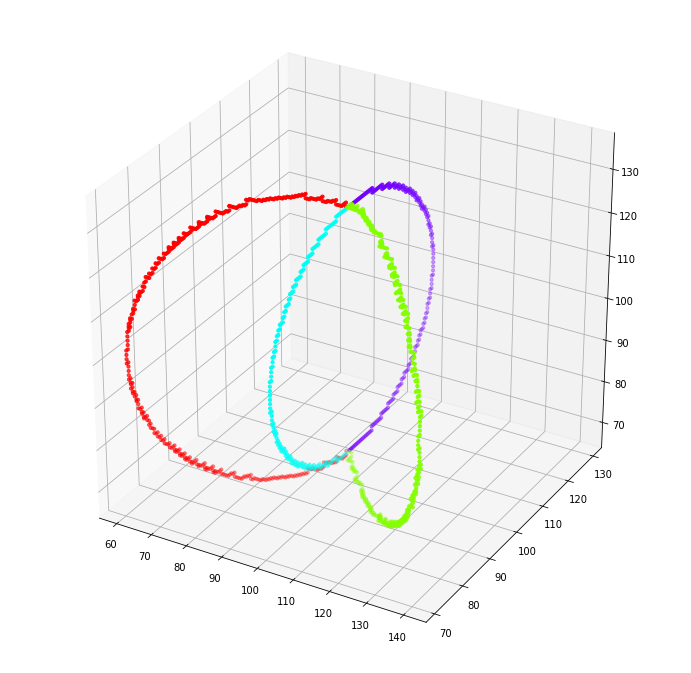

In [10]:
### Show identified TJs as 3D scatter

# Prepare the plot
fig = plt.figure(figsize=(12,12))
ax  = fig.add_subplot(111, projection='3d')

# Plot each TJ in a different color
for TJ_num,TJ_ID in enumerate(TJs.keys()):
    ax.scatter(TNCs[TJs[TJ_ID]][:,2], TNCs[TJs[TJ_ID]][:,1], TNCs[TJs[TJ_ID]][:,0],
               c=[TJ_num for _ in range(TJs[TJ_ID].shape[0])], 
               cmap='hsv', vmin=0, vmax=len(TJs), s=10)

## Also show cell outlines [may take several seconds to render!]
#ax.scatter([c[2] for c in OCs],
#           [c[1] for c in OCs],
#           [c[0] for c in OCs],
#           c='gray', alpha=0.01, linewidth=0, s=5)

## Axis limits
#ax.set_xlim([0,200])
#ax.set_ylim([0,200])
#ax.set_zlim([0,200])

# Finish
plt.show()

### Fitting Splines to TJs

Turns out spline fitting requires the input points to be roughly in order along the spline, which isn't guaranteed in our case. Ordering the points happens to be far harder problem than one might imagine (it's a variation of traveling salesman) but luckily it can be solved quite well with a Breadth-First Search (BFS). This solution is partially inspired by Imanol Luengo's answer to [this SO question](https://stackoverflow.com/questions/37742358/sorting-points-to-form-a-continuous-line).

<font color=orange>**Warning 1:**</font> This will fail for geometries that exhibit "crossings" or "forks" of any kind. Although that should be very rare/non-existent in the data, a special form of "fork" is the circle. In case of a fully circular TJ, which occurs when two cells neatly touch each other, this will fail (unless some points are removed from the TJ). I couldn't come up with a way of fixing this but divised the `InvalidPathError` to at least pick up on such cases. However, **it may be too stringent** as it is currently implemented!

<font color=orange>**Warning 2:**</font> Simply rescaling the z axis a little bit already led to renewed problems with this approach, so I'm starting to seriously doubt its robustness. We'll have to keep a close eye on this and possibly somehow develop a better solution if problems keep cropping up. Maybe some sort of modified graph search (rather than straight up BFS) would be a possibility...

In [11]:
### Function to reorder TEs along the progression of the TJ

# FLAG: ROBUSTNESS -- I have my doubts as to the robustness of this approach (see warnings above)!

def sort_line_coords(coords, N_neighbors=10, source=None, 
                     return_argsort=False, ignore_path_check=False):
    """Given a set of coordinates that roughly lie on a 1D curve in mD space
    (but may be in random order), sort the points such that they roughly follow 
    the curve's progression.
    
    Uses a breadth-first search tree on a nearest-neighbor graph of the coords,
    which happens to result in the best possible sort. Does not work as intended
    for closed curves and curves that form any kind of fork or crossing; an 
    Error is raised in such cases.
    
    Parameters
    ----------
    coords : array of shape (N_points, M_dimensions)
        Coordinates of points roughly lying on a point in M-dimensional space.
    N_neighbors : int, optional, default 10
        Number of nearest neighbors to include for each graph. If this is set
        too low, connected components may form and no complete solution is
        possible (raises an Exception). If this is set too high, the resulting
        sort is very imprecises. The ideal value must be determined empirically.
        When used to prepare TJs for spline fitting in the context of pyCFI, the
        default (10) is a reasonably choice and the outcome is largely robust
        to changes between values of 5 and 20.
    source : None or int, optional, default None
        The source is a point at one of the two ends of the line. If None, the
        point is automatically determined by testing all different points and 
        selecting the one that yields the best sort (by minimizing the resulting
        path distance). If source is an int, it indexes into coords to specify
        the end point from which the sort is constructed. This saves a lot of
        time compared to the automated search, especially if there are many
        points, however it requires prior knowledge of the end point.
    return_argsort : bool, optional, default False
        If True, the index array that sorts the points into the best order is 
        returned as a second result. Otherwise, only a sorted version of coords 
        is returned.
    ignore_path_check : bool, optional, default False
        If True, the final path is not cross-checked and no InvalidPathErrors
        can be raised (see Exceptions below).
    
    Returns
    -------
    sorted_coords : array of shape (N_points, M_dimensions)
        The same set of points as in the input coords but sorted along the
        curve's progression in space.
    best_path : array of shape (N_points,)

Index array that sorts points along the curve's progression in space. 
        Only returned if return_argsort is set to True.
        
    Exceptions
    ----------
    InvalidPathError : If the curve is closed or contains forks/crossings, the
        sort fails, which is reflected in the fact that the final path will
        contain steps that do not have corresponding edges on the graph. In
        this case, InvalidPathError is raised. This may also occur under other
        dubious circumstances, e.g. if the input data is not a curve at all 
        or if it is a very broad curve or if N_neighbors is too low.
    """
    
    # Get pairwise distances (if needed)
    if source is None:
        dists = spatial.distance.squareform(spatial.distance.pdist(coords))
    
    # Get nearest neighbors
    kdtree  = spatial.cKDTree(coords)
    _, KNNs = kdtree.query(coords, k=N_neighbors)
    
    # Build adjacency matrix
    adj_M = np.zeros((coords.shape[0], coords.shape[0]), dtype=np.bool)
    for i,N in enumerate(KNNs):
        adj_M[i,N] = True
    
    # Construct networkx graph
    G = nx.from_numpy_array(adj_M)
    if not nx.is_connected(G):
        raise Exception('sort_line_coords: adjacency graph is not fully connected!')
     
    # If a source node is given, just get its BFS tree
    if source is not None:
        best_path = list(nx.bfs_tree(G, source))
        
    # Otherwise, find the best BFS tree from all sources
    if source is None:
        paths = []
        costs = []
        for n in G.nodes():

            # Get BFS tree
            path = list(nx.bfs_tree(G, n))

            # Get sum of all distances within tree
            cost = 0.0
            for n0,n1 in zip(path, path[1:]):
                cost += dists[n0, n1]

            # Keep results
            paths.append(path)
            costs.append(cost)

        # Select the best solution
        best_path = paths[np.argmin(costs)]
    
    # Test for cases that probably failed
    if not ignore_path_check:
        for p1,p2 in zip(best_path, best_path[1:]):
            if not G.has_edge(p1,p2):
                class InvalidPathError(Exception): pass
                raise InvalidPathError("The sort path uses an edge that is not on the graph. "+
                                       "This should not happen and probably implies that the "+
                                       "curve is cyclical or has a fork/crossing.")
    
    # Sort coords and return
    if return_argsort:
        return coords[best_path], best_path
    else:
        return coords[best_path]

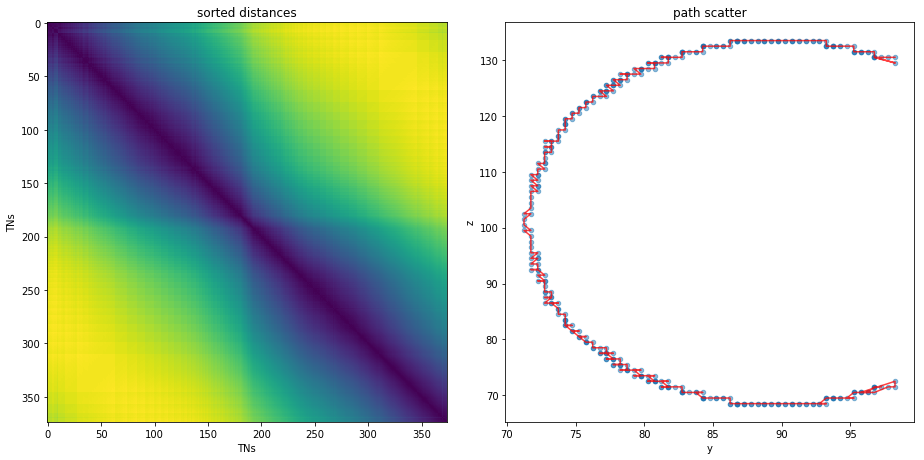

In [12]:
### A quick test of the TJ sorting

# FLAG: ROBUSTNESS -- Currently, ingore_path_check has to be set to True for this to work
#                     when z is properly rescaled (although the sort overall actually
#                     doesn't look too bad).

# Grab a TJ and compute the sort
TJCs = TNCs[TJs[list(TJs.keys())[0]]]
sorted_TJCs = sort_line_coords(TJCs, ignore_path_check=True)

# Get sorted pairwise distances
sorted_dists = spatial.distance.squareform(spatial.distance.pdist(sorted_TJCs))

# Plot pairwise distances
fig, ax = plt.subplots(1, 2, figsize=(13,6.5))
ax[0].imshow(sorted_dists)
ax[0].set_title("sorted distances")
ax[0].set_xlabel('TNs'); ax[0].set_ylabel('TNs')

# Plot path/tree on scatter
ax[1].scatter(TJCs[:,1], TJCs[:,0], s=20, alpha=0.5)
ax[1].plot(sorted_TJCs[:,1], sorted_TJCs[:,0], c='r', alpha=0.75)
ax[1].set_title("path scatter")
ax[1].set_xlabel('y'); ax[1].set_ylabel('z')

# Done
plt.tight_layout()
plt.show()

In [13]:
### Wrapper for spline fitting

def wrap_splprep(coords, k=3, verbose=False):
    """Fit an nD spline with scipy.interpolate.splprep.
    
    coords : array (points, dimensions) : input data
    k=3 : integer : degrees of freedom
    verbose=False : bool : wether to print all outputs
    
    returns -> tck : tuple (knots, coefficients, k) : 
               fit parameters as used by splev
    """
    
    # Fit the spline and unpack the (weirdly packaged) results
    tcku, fp, ier, msg = interpolate.splprep(coords.T, k=k, full_output=True)
    tck, u = tcku

    # Report the results
    if verbose:
        print ('\nt (knots, tck[0]):\n' , tck[0])
        print ('\nc (coefficients, tck[1]):\n' , tck[1])
        print ('\nk (degree, tck[2]):' , tck[2])
        print ('\nu (evaluation points):\n', u)
        print ('\nfp (residual error):', fp)
        print ('\nier (error code; success is ier<=0):', ier)
        print ('\nmsg (message from FITPACK):\n', msg)
        
    # Raise an error if FITPACK indicates failure
    if ier > 0:
        raise Exception('ier is >0, indicating that FITPACK failed somehow. '+
                        'The message from FITPACK was:\n'+msg)
        
    # Return the only result relevant to spline evaluation
    return tck

In [14]:
### Perform sorting and spline fitting on all TJs

# Output dicts
TJs_spline_tck     = {}  # Fitted splines for each TJ
TJs_spline_ev      = {}  # Evaluated splines for each TJ
TJs_spline_tangent = {}  # Tangents to splines for each TJ

# For each TJ...
for TJ_ID in TJs.keys():
    
    # Sort coordinates along the line
    sorted_TJCs, TJ_argsort = sort_line_coords(TNCs[TJs[TJ_ID]],
                                               return_argsort=True,
                                               ignore_path_check=True)
    TJs[TJ_ID] = TJs[TJ_ID][TJ_argsort]
    
    # Perform spline fitting
    tck = wrap_splprep(sorted_TJCs)
    TJs_spline_tck[TJ_ID] = tck
    
    # Evaluate the spline in 1000 regular intervals
    ev = interpolate.splev(np.linspace(0.0, 1.0, 1000), tck)
    ev = np.array(ev).T
    TJs_spline_ev[TJ_ID] = ev
    
    # Also evaluate with slight deviation forward and backward
    evD1 = np.array(interpolate.splev(np.linspace(0.0, 1.0, 1000)+10e-2, tck)).T
    evD2 = np.array(interpolate.splev(np.linspace(0.0, 1.0, 1000)-10e-2, tck)).T
    
    # Approximate the tangent vector as the sum of the deviatory vectors
    tangent_vec = (evD1 - ev) + (ev - evD2)
    TJs_spline_tangent[TJ_ID] = tangent_vec

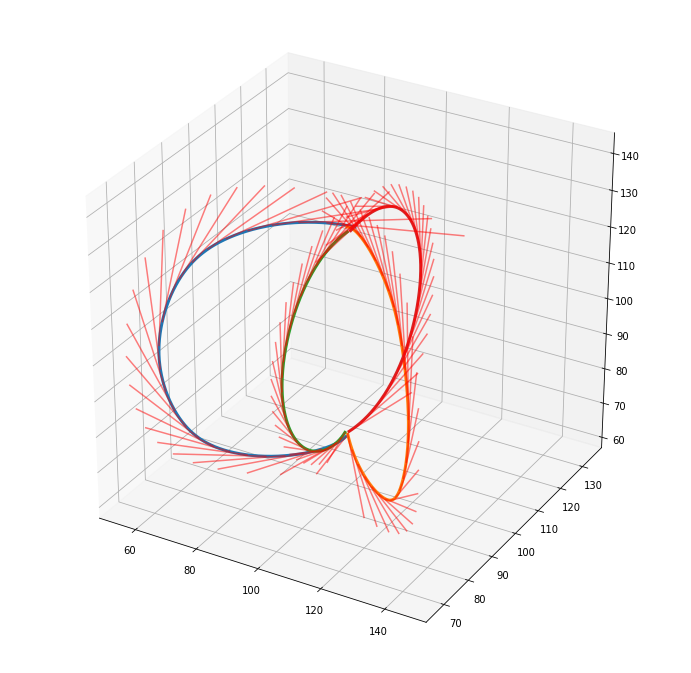

In [15]:
### Visualize the fitted splines and the tangent vectors as 3D scatter

# Prepare the plot
fig = plt.figure(figsize=(12,12))
ax  = fig.add_subplot(111, projection='3d')

# Plot each TJ spline
for TJ_num,TJ_ID in enumerate(TJs.keys()):
    ax.plot(TJs_spline_ev[TJ_ID][:,2], 
            TJs_spline_ev[TJ_ID][:,1], 
            TJs_spline_ev[TJ_ID][:,0],
            lw=3)

# Add the tangent vectors
for TJ_num, TJ_ID in enumerate(TJs.keys()):
    for splpt, tngvec in zip(TJs_spline_ev[TJ_ID][::40], TJs_spline_tangent[TJ_ID][::40]):
        plt.plot([splpt[2], splpt[2]+tngvec[2]],
                 [splpt[1], splpt[1]+tngvec[1]],
                 [splpt[0], splpt[0]+tngvec[0]],
                 'r-', alpha=0.5)
            
## Axis limits
#ax.set_xlim([0,200])
#ax.set_ylim([0,200])
#ax.set_zlim([0,200])

# Finish
plt.show()

In [54]:
### Get paths through the image stack from the splines

# FLAG: ISSUE -- The "voxels" here are in real space (res), not in image space! This could lead to mismatches!
# FLAG: DATA STRUCTURES -- You may need to (or even prefer to) keep the indices of voxels into the spline!

# Prep dicts
TJs_spline_vox  = {}  # All voxels visited by the spline
TJs_spline_voxz = {}  # One voxel per unique visit of the spline to a z-plane

# For each TJ...
for TJ_ID in TJs_spline_ev.keys():
    
    # Get relevant spline points
    ev = TJs_spline_ev[TJ_ID]
    
    # Go through the points and keep only those in new voxels/z-planes
    TJs_spline_vox[TJ_ID]  = [ev[0].astype(np.int)]
    TJs_spline_voxz[TJ_ID] = [ev[0].astype(np.int)]
    for pt in ev[1:]:
        pt_vox = pt.astype(np.int)
        if not np.all(pt_vox == TJs_spline_vox[TJ_ID][-1]):
            TJs_spline_vox[TJ_ID].append(pt_vox)
        if pt_vox[0] != TJs_spline_voxz[TJ_ID][-1][0]:
            TJs_spline_voxz[TJ_ID].append(pt_vox)
    
    # Convert result to array
    TJs_spline_vox[TJ_ID]  = np.array(TJs_spline_vox[TJ_ID])
    TJs_spline_voxz[TJ_ID] = np.array(TJs_spline_voxz[TJ_ID])

### Retrieving Incident Vectors in the Sectioning Plane

In [56]:
### Find coordinates of all voxels involved in DOUBLE junctions

# FLAG: PERFORMANCE -- Same as for TNI/TNC extraction above!
# FLAG: PRECISION -- Same as for TNI/TNC extraction above!

# Go through OIs and find Double Node Indices (DNIs)
DNIs = []
for OI in OIs:
    selection = im_pad[OI[0]:OI[0]+2, OI[1]:OI[1]+2, OI[2]:OI[2]+2]
    if len(set(selection.flatten())) == 2:
        DNIs.append(OI)
DNIs = np.array(DNIs)

# Convert to DN Coordinates (DNCs)
DNCs = (DNIs + 0.5) * res

# Report
print('OCs: ', OCs.shape)
print('DNIs:', DNIs.shape)
print('DNCs:', DNCs.shape)

OCs:  (254738, 3)
DNIs: (154342, 3)
DNCs: (154342, 3)


In [57]:
### Build a dict of Double Junctions (DJs) structured as: {tuple(cell1_ID, cell2_ID) : array(INDICES INTO DNIs/DNCs)}

# Prepare defaultdict
DJs = collections.defaultdict(lambda : [])

# Go through DNs, create IDs, assign coordinates to IDs
for idx,DNI in enumerate(DNIs):
    selection = im_pad[np.int(DNI[0]):np.int(DNI[0])+2, 
                       np.int(DNI[1]):np.int(DNI[1])+2, 
                       np.int(DNI[2]):np.int(DNI[2])+2]
    DJ_ID = tuple(sorted(set(selection.flatten())))
    DJs[DJ_ID].append(idx)

# Convert DJ lists to numpy arrays
for key in DJs.keys():
    DJs[key] = np.array(DJs[key])

In [77]:
### Show identified DJs on image stack

@interact(z=(0, im.shape[0]-1, 1))
def show_stack(z=im.shape[0]//2):
    
    # Prep and plot image
    plt.figure(figsize=(8,8))
    plt.imshow(outlines_id[z], cmap='gray')
    
    # For each DJ...
    for DJ_num,DJ_ID in enumerate(DJs.keys()):
        
        # Get the DJ's DNs in the selected z plane
        DNs_in_plane = DNIs[DJs[DJ_ID]][DNIs[DJs[DJ_ID]][:,0]==z]
        
        # Plot the points
        plt.scatter(DNs_in_plane[:, 2], DNs_in_plane[:, 1],
                    c=[DJ_num for _ in range(DNs_in_plane.shape[0])], # Coloring trick!
                    cmap='hsv', vmin=0, vmax=len(DJs), s=20)
        
    # Finish
    plt.show()

interactive(children=(IntSlider(value=100, description='z', max=199), Output()), _dom_classes=('widget-interac…

In [126]:
### Helpful functions for circular arc fitting 

# Compute coordinates from angle
def circle(r, cx, cy, alpha):
    x = r*np.cos(alpha) + cx
    y = r*np.sin(alpha) + cy
    return np.array([y,x])

# Sum of square deviation given circle params (r, cx, cy)
def circle_loss(params, x, y):
    r, cx, cy = params
    loss = np.sqrt((x-cx)**2 + (y-cy)**2) - r
    return np.sum(loss**2)

# Subtraction of n1 and n2, wrapping around at minimum and maximum
def wrap_sub(n1, n2, minimum=-np.pi, maximum=np.pi):
    s = n1 - n2 
    try:
        s[s<=minimum] = maximum + (s[s<=minimum] - minimum)
        s[s>=maximum] = minimum + (s[s>=maximum] - maximum)
    except TypeError:
        if s <= minimum: s = maximum + (s - minimum)
        if s >= maximum: s = minimum + (s - maximum)
    return s

In [125]:
### Find incident vectors for each TN based on circular arc fitting

# FLAG: ISSUE -- This needs to be double-checked. I have a feeling that there may be some
#                discrepancies remaining between TJs_spline_vox and DNCs!
# FLAG: SIMPLICITY -- This code seems a bit cumbersome. I think this may stem from the fact
#                     that the code in general is written with a very 3D mindset whilst the
#                     Brodland approach implemented here is still a 2D thing at this point!
# FLAG: PERFORMANCE -- This takes a bit of time. There may be ways of speeding it up.
#                      Note that some time can simply be saved by using TJs_spline_voxz
#                      instead of TJs_spline_vox.
# FLAG: ROBUSTNESS -- When all relevant DN points in a given case are EXACTLY in a straight 
#                     line, this approach to arc fitting has an unwanted local minimum and 
#                     will thus yield a wrong result!

# Params
close_points_radius = 25.0

# Output
TJs_vec_raw = {}

# For each TJ...
for TJ_ID in TJs_spline_vox.keys():
    
    # Find the IDs of the three connected interfaces
    DJ_IDs = list(itertools.combinations(TJ_ID, 2))
    
    # Skip edge cases with more than 3
    if len(DJ_IDs) > 3:
        continue
        
    # Prepare an appropriate result array
    TJs_vec_raw[TJ_ID] = np.empty((TJs_spline_vox[TJ_ID].shape[0], 3, 3))  # Num. of TNs, 3 vectors, 3 dimensions
    TJs_vec_raw[TJ_ID].fill(np.nan)
    
    # For each TN of the current TJ...
    for TN_idx, TN in enumerate(TJs_spline_vox[TJ_ID]): 
        
        # For each connected interface...
        for DJ_idx, DJ_ID in enumerate(DJ_IDs):
            
            # Get all the DJ points of the interface in the TN's z-plane
            DNCs_z = DNCs[DJs[DJ_ID]][np.floor(DNCs[DJs[DJ_ID]][:,0])==np.floor(TN[0])]
            
            # If there are non, skip this TN
            if DNCs_z.size == 0:
                print("Skipped case at TJ_ID="+str(TJ_ID) + ", TN_idx=" +str(TN_idx) + 
                      ", DJ_ID="+str(DJ_ID)+" ->> lacks interface points!")
                continue
                
            # Get the DN points close to the TN
            kdtree = spatial.cKDTree(DNCs_z)
            KNNs   = kdtree.query_ball_point(TN, close_points_radius)
            
            # If there are none, skip this TE
            if not KNNs:
                print("Skipped case at TJ_ID="+str(TJ_ID) + ", TN_idx=" +str(TN_idx) + 
                      ", DJ_ID="+str(DJ_ID)+" ->> no close-by neighbors!")
                continue
            
            # Fit a circle
            x = np.concatenate([DNCs_z[KNNs,2], TN[2,np.newaxis]])
            y = np.concatenate([DNCs_z[KNNs,1], TN[1,np.newaxis]])
            with np.errstate(divide='ignore'):
                fit = optimize.minimize(circle_loss, [1.0, np.mean(x), np.mean(y)], args=(x, y))

            r, cx, cy = fit.x
            
            # Get angular position of the TN point
            TN_alpha = np.arctan2(TN[1]-cy, TN[2]-cx)
            
            # Get correct sign for tangent vector direction
            DNs_alpha = wrap_sub(np.arctan2(y-cy, x-cx), TN_alpha)
            sign = np.sign(np.mean(DNs_alpha))

            # Get tangent vector based on TN angle and small shift
            TN_proj = circle(r, cx, cy, TN_alpha)
            shifted = circle(r, cx, cy, TN_alpha+10e-5)
            tangent = shifted - TN_proj
            tangent = tangent * sign
            
            # Normalize to magnitude 1
            tangent = tangent / np.sqrt(np.sum(tangent**2.0))
            
            # Save the result
            TJs_vec_raw[TJ_ID][TN_idx, DJ_idx, 0]  = 0.0
            TJs_vec_raw[TJ_ID][TN_idx, DJ_idx, 1:] = tangent

Skipped case at TJ_ID=(0, 1, 2), TN_idx=0, DJ_ID=(0, 1) ->> no close-by neighbors!
Skipped case at TJ_ID=(0, 1, 2), TN_idx=1, DJ_ID=(0, 1) ->> no close-by neighbors!
Skipped case at TJ_ID=(0, 1, 3), TN_idx=0, DJ_ID=(0, 1) ->> no close-by neighbors!
Skipped case at TJ_ID=(0, 1, 3), TN_idx=193, DJ_ID=(0, 1) ->> no close-by neighbors!
Skipped case at TJ_ID=(0, 1, 3), TN_idx=194, DJ_ID=(0, 1) ->> no close-by neighbors!
Skipped case at TJ_ID=(0, 2, 3), TN_idx=1, DJ_ID=(2, 3) ->> lacks interface points!
Skipped case at TJ_ID=(0, 2, 3), TN_idx=2, DJ_ID=(2, 3) ->> lacks interface points!
Skipped case at TJ_ID=(0, 2, 3), TN_idx=3, DJ_ID=(2, 3) ->> lacks interface points!
Skipped case at TJ_ID=(0, 2, 3), TN_idx=4, DJ_ID=(2, 3) ->> lacks interface points!
Skipped case at TJ_ID=(0, 2, 3), TN_idx=5, DJ_ID=(2, 3) ->> lacks interface points!
Skipped case at TJ_ID=(0, 2, 3), TN_idx=6, DJ_ID=(2, 3) ->> lacks interface points!
Skipped case at TJ_ID=(0, 2, 3), TN_idx=7, DJ_ID=(2, 3) ->> lacks interface p

In [131]:
### Visualize the resulting vectors

@interact(z=(0, im.shape[0]-1, 1))
def show_stack(z=im.shape[0]//2):
    
    # Prep and plot image
    plt.figure(figsize=(8,8))
    plt.imshow(outlines_id[z], cmap='gray')
    
    # For each TJ...
    for TJ_num, TJ_ID in enumerate(TJs_vec_raw.keys()):
        
        # Find indices of TNs in this plane (skip if none)
        in_plane_indices = np.where(np.floor(TJs_spline_vox[TJ_ID][:,0])==z)[0]
        if in_plane_indices.size == 0:
            continue
        
        # For each such TN...
        for TN_idx in in_plane_indices:
            
            # Get TE and vector coordinates
            TN   = TJs_spline_vox[TJ_ID][TN_idx]
            vecs = TJs_vec_raw[TJ_ID][TN_idx]
        
            # Convert back to image space
            TN = (TN / res) - 0.5
            vecs = (vecs / res)
        
            # Plot all the vectors
            for vec in vecs:
                plt.plot([TN[2], TN[2]+vec[2]*10], 
                         [TN[1], TN[1]+vec[1]*10],
                         'r-', lw=2)
        
    # Finish
    #plt.xlim([100,150])
    #plt.ylim([110,160])
    plt.show()

interactive(children=(IntSlider(value=100, description='z', max=199), Output()), _dom_classes=('widget-interac…

## <font color=red>YAH!</font>

### Projecting Incident Vectors onto the TJ-Orthogonal Plane

In [ ]:
### Sympy function to project close-by outline points onto a TE's orthogonal plane

# TODO: Encode the numpy func so that the symbolic stuff doesn't need to be run
#       each time the code is executed!

# Import sympy stuff
import sympy as sym
from sympy.abc import q,r,s,  x,y,z  # (normal vector), (point to be projected)

# Use Gram-Schmidt orthogonalization to create orthonormal vectors defining the in-plane
# coordinate system given three arbitrary vectors, the first of which is the normal vector
# of the plane. The other two (defining the in-plane directionalities) are arbitrarily 
# chosen such that they will never fall onto the normal vector or onto each other.
orthonormals = sym.GramSchmidt([sym.Matrix([q,    r,  s]),  # Normal vec to plane -> first coordinate vec
                                sym.Matrix([q,  2*r,3*s]),  # Arbitrary vec not on the normal vec
                                sym.Matrix([2*q,3*r,  s])], # Arbitrary vec not on either other vec
                                orthonormal=True)           # Normalize resulting orthogonal vectors

## One problem is that small changes in the input normal can lead to large changes
## in the plane's orientation if the input values are close to zero.
## [TODO: DESCRIPTION OF SOLUTION]
## DEV-TEMP: I think this fixes the flipping but I'm not quite sure yet;
##           the results still have lots of problems but these may come from
##           other sources, so before coming back to this the normal vectors
##           and the orthogonalization per se need to be double-checked!
#reference_pt = sym.Matrix([1.0, 1.0, 1.0])
#ref_d = orthonormals[0].dot(reference_pt)
#ref_u = orthonormals[1].dot(reference_pt)
#ref_v = orthonormals[2].dot(reference_pt)
##orthonormals[0] = orthonormals[0] * sym.sign(ref_d)
##orthonormals[1] = orthonormals[1] * sym.sign(ref_u)
##orthonormals[2] = orthonormals[2] * sym.sign(ref_v)
## Not sure the zero case is even really triggered here (due to float issues)
#orthonormals[0] = orthonormals[0] * sym.Piecewise((1.0, sym.Eq(ref_d, 0.0)), (sym.sign(ref_d), True))
#orthonormals[1] = orthonormals[1] * sym.Piecewise((1.0, sym.Eq(ref_u, 0.0)), (sym.sign(ref_u), True))
#orthonormals[2] = orthonormals[2] * sym.Piecewise((1.0, sym.Eq(ref_v, 0.0)), (sym.sign(ref_v), True))

# With the resulting orthonormals defining the new coordinate system, the projection
# of points into it is just a straightforward dot product.
projection_pt = sym.Matrix([x, y, z])
proj_d = orthonormals[0].dot(projection_pt)  # Distance from plane
proj_u = orthonormals[1].dot(projection_pt)  # Coordinate along first axis in plane
proj_v = orthonormals[2].dot(projection_pt)  # Coordinate along second axis in plane

# Lambdify
lambda_dist = sym.utilities.lambdify((q,r,s,x,y,z), proj_d, modules='numpy')
lambda_u    = sym.utilities.lambdify((q,r,s,x,y,z), proj_u, modules='numpy')
lambda_v    = sym.utilities.lambdify((q,r,s,x,y,z), proj_v, modules='numpy')

# Wrap
def p2p_projection(normal_vec, pt_coords):
    
    # Unpack inputs
    q,r,s = normal_vec[2], normal_vec[1], normal_vec[0]
    x,y,z = pt_coords[:,2], pt_coords[:,1], pt_coords[:,0]
    
    # Run projection
    dists = np.abs(lambda_dist(q,r,s,x,y,z))
    p_u   = lambda_u(q,r,s,x,y,z)
    p_v   = lambda_v(q,r,s,x,y,z)
    
    # Pack and return outputs
    projected = np.array([p_u, p_v]).T
    return projected, dists

# Wrap (all at once version)
def p2p_projection2(normal_vec, pt_coords):
    
    # Unpack inputs
    q,r,s = normal_vec[..., 2, np.newaxis], normal_vec[..., 1, np.newaxis], normal_vec[..., 0, np.newaxis]
    x,y,z = pt_coords[..., 2], pt_coords[..., 1], pt_coords[..., 0]
    
    # Run projection
    dists = np.abs(lambda_dist(q,r,s,x,y,z))
    p_u   = lambda_u(q,r,s,x,y,z)
    p_v   = lambda_v(q,r,s,x,y,z)
    
    # Pack and return outputs
    projected = np.rollaxis(np.array([p_u, p_v]), 2)
    projected = np.rollaxis(projected, 2)
    return projected, dists

In [ ]:
### Project vectors onto the TJ-orthogonal plane (using Vivek's p2p projection)
### NOTE: Some of the "gets" at the top of this code are redundant to cross-check
###       that the result is correct. This can be either codified as tests or
###       removed entirely in future.

# For reach TJ
TJs_vec_proj = {}
for TJ_ID in TJs_vec.keys():
    print(TJ_ID)
    
    # Get vectors
    vecs = TJs_vec[TJ_ID]
    
    # Get the spline point indices of the splvox TEs
    idx = TJs_splvox_idx[TJ_ID]
    
    # Get the corresponding spline points
    spl_TEs = TJs_splvox[TJ_ID]
    
    # Get the parameter values of those spline points
    t = np.linspace(0.0, 1.0, 1000)[idx]
    
    # Re-evaluate the spline based on this
    ev = np.array(interpolate.splev(t, TJs_spltck[TJ_ID])).T
    
    # Get already computed tangent vectors
    tng = TJs_spltng[TJ_ID][idx]
    
    # Re-compute to double-check
    evD1 = np.array(interpolate.splev(t+10e-2, TJs_spltck[TJ_ID])).T
    evD2 = np.array(interpolate.splev(t-10e-2, TJs_spltck[TJ_ID])).T
    tangent_vec = (evD1 - ev) + (ev - evD2)
    
    # Project vectors onto normal plane
    projs = []
    for normal, vec in zip(tng, vecs):
        proj, _ = p2p_projection(normal, vec)
        proj = (proj.T / np.sqrt(np.sum(proj**2.0, axis=1))).T
        projs.append(proj)
    projs = np.array(projs)
    TJs_vec_proj[TJ_ID] = projs
    
    ## ALL AT ONCE
    #projs, _ = p2p_projection2(tng, vecs)
    
    ## Check it
    #plt.figure()
    #plt.plot(t, projs[:,0,0])#/np.abs(projs[:,0,0]).max())
    #plt.plot(t, projs[:,0,1])#/np.abs(projs[:,0,1]).max())
    #plt.plot(t, vecs[:,2,0], 'k', label='')
    ##plt.plot(t, vecs[:,2,1], label='y')
    ##plt.plot(t, vecs[:,2,2], label='x')
    ##plt.plot(t, tng[:,0]/tng[:,0].max(), label='z')
    #plt.plot(t, tng[:,1]/tng[:,1].max(), label='y')
    #plt.plot(t, tng[:,2]/tng[:,2].max(), label='x')
    #plt.legend()
    ##plt.plot(t, [106.4379 for _ in t], 'k')
    #plt.show()

In [ ]:
for TJ_ID in TJs_vec_proj.keys():
    plt.figure()
    cols = ['r','g','b']
    for vec in TJs_vec_proj[TJ_ID]:
        for i,v in enumerate(vec):
            plt.plot([0,v[1]], [0,v[0]], c=cols[i])
    plt.axis('equal')
    plt.show()

### Finding a Consensus Incident Vector Triplet for each TJ

In [ ]:
### Align triplets based on first vector & flip those that are the wrong way around
### Note 1: The flipping is an in-post fix for cases where the plane itself flipped 
###         due to the sensitivity of Gram-Schmidt to the vector's sign.
### Note 2: This should be cleaned and the inner loops can probably be vectorized!

# For each TJ...
TJs_vec_aligned = {}
for TJ_ID in TJs_vec_proj.keys():
    
    # Prep output container
    triplets_aligned = np.empty_like(TJs_vec_proj[TJ_ID])
    
    # Rotate each triplet to lay the first vector onto zero angle
    angles_zeroed = np.empty((TJs_vec_proj[TJ_ID].shape[0], 3))
    for t,triplet in enumerate(TJs_vec_proj[TJ_ID]):
        angles_raw = np.arctan2(triplet[:,0], triplet[:,1])
        angles_zeroed[t] = angles_raw - angles_raw[0]
 
    # If flipped is better than the consensus (here the median), then flip
    # Do this a couple of times for robustness... [NOTE: This should be improved somehow!]
    for i in range(10):
        median = np.median(angles_zeroed, axis=0)
        for t in range(len(angles_zeroed)):
            diff_original = np.abs(wrap_sub(angles_zeroed[t], median)) 
            diff_flipped  = np.abs(wrap_sub(-angles_zeroed[t], median))
            if np.sum(diff_flipped) < np.sum(diff_original):
                angles_zeroed[t] = - angles_zeroed[t]
    
    # Convert back to unit vectors
    for t in range(len(angles_zeroed)):
        triplets_aligned[t] = circle(1.0, 0.0, 0.0, angles_zeroed[t]).T
        
    # Store results
    TJs_vec_aligned[TJ_ID] = triplets_aligned

In [ ]:
for TJ_ID in TJs_vec_aligned.keys():
    plt.figure()
    cols = ['r','g','b']
    for vec in TJs_vec_aligned[TJ_ID]:
        for i,v in enumerate(vec):
            plt.plot([0,v[1]], [0,v[0]], c=cols[i])
    plt.axis('equal')
    plt.show()
    
# Okay... so clearly allowing mirroring (on the first axis) would solve most issues!

### Solving the Force Balance Equations

In [ ]:
V = {}
for TJ_ID in TJs_vec_aligned.keys():
    n_TEs = TJs_vec_aligned[TJ_ID].shape[0]
    V[TJ_ID] = TJs_vec_aligned[TJ_ID][n_TEs//2-10:n_TEs//2+10, :].mean(axis=0)

In [ ]:
G = np.zeros((2*len(V), len(ICs)))
for TJ_idx, TJ_ID in enumerate(V.keys()):
    for IC_idx, IC_ID in enumerate(ICs.keys()):
        
        try:
            IC_ref = list(itertools.combinations(TJ_ID, 2)).index(IC_ID)
            G[TJ_idx, IC_idx] = V[TJ_ID][IC_ref][0]
            G[len(V.keys())+TJ_idx, IC_idx] = V[TJ_ID][IC_ref][1]
        except Exception:
            pass

In [ ]:
plt.imshow(np.abs(G))
plt.show()

#### Using Minimize to its Full Extent :)

In [ ]:
def loss(gammas, G):
    loss = (np.dot(G, gammas))**2.0
    return np.sum(loss)

def constraint(gammas):
    c = np.mean(gammas) - 1
    return c

In [ ]:
fit = optimize.minimize(loss, np.ones(len(ICs)), args=(G,), 
                        constraints={'type':'eq', 'fun':constraint})

In [ ]:
tensions = fit.x

In [ ]:
tensions

In [ ]:
### Show TENSIONS on image stack

@interact(z=(0, im.shape[0]-1, 1))
def show_stack(z=im.shape[0]//2):
    
    # Prep and plot image
    plt.figure(figsize=(8,8))
    plt.imshow(outlines_id[z], cmap='gray')
    
    # For each IC...
    for IC_num,IC_ID in enumerate(ICs.keys()):
        
        # Get the IC's OCs in the selected z plane
        OCs_in_plane = ICs[IC_ID][np.floor(ICs[IC_ID][:,0])==z]
        
        # Plot the points (note the curios way of setting the color!)
        plt.scatter(OCs_in_plane[:, 2], OCs_in_plane[:, 1],
                    c=[tensions[IC_num] for _ in range(OCs_in_plane.shape[0])],
                    vmin=np.min(tensions), vmax=np.max(tensions),
                    cmap='viridis', s=20)
    plt.colorbar()
        
    # Finish
    plt.show()

#### Using Brodland et alii's Brains

In [ ]:
Gdot = np.dot(G.T, G)

In [ ]:
plt.imshow(Gdot)
plt.show()

In [ ]:
Gready = np.zeros((Gdot.shape[0]+1, Gdot.shape[1]+1))
Gready[:Gdot.shape[0], :Gdot.shape[1]] = Gdot
Gready[-1,:-1] = 1.0
Gready[:-1,-1] = 1.0

In [ ]:
plt.imshow(Gready)
plt.show()

In [ ]:
def loss(gammas_lagrange, Gready):
    loss = np.sum(np.dot(Gready[:-1], gammas_lagrange)**2.0)
    loss += (np.dot(Gready[-1], gammas_lagrange) - (gammas_lagrange.size-1))**2.0
    return loss

In [ ]:
fit = optimize.minimize(loss, np.ones(len(ICs)+1), args=(Gready,))

In [ ]:
tensions = fit.x[:-1]
lagrange = fit.x[-1]

In [ ]:
tensions

In [ ]:
### Show TENSIONS on image stack

@interact(z=(0, im.shape[0]-1, 1))
def show_stack(z=im.shape[0]//2):
    
    # Prep and plot image
    plt.figure(figsize=(8,8))
    plt.imshow(outlines_id[z], cmap='gray')
    
    # For each IC...
    for IC_num,IC_ID in enumerate(ICs.keys()):
        
        # Get the IC's OCs in the selected z plane
        OCs_in_plane = ICs[IC_ID][np.floor(ICs[IC_ID][:,0])==z]
        
        # Plot the points (note the curios way of setting the color!)
        plt.scatter(OCs_in_plane[:, 2], OCs_in_plane[:, 1],
                    c=[tensions[IC_num] for _ in range(OCs_in_plane.shape[0])],
                    vmin=np.min(tensions), vmax=np.max(tensions),
                    cmap='viridis', s=20)
    plt.colorbar()
        
    # Finish
    plt.show()